**CS412 Term Project Dataoctrats**

**Step 1** Initlialization of the libraries we will need.

In [ ]:
#importing needed libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, accuracy_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import nltk
import string
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Step 2** Initliazation of drive and data.

In [ ]:
#mounting google drive to access files
from google.colab import drive
drive.mount('/content/drive')

data =  pd.read_csv('/content/drive/MyDrive/cs412/Term Project/bugs-train.csv')
testing  = pd.read_csv('/content/drive/MyDrive/cs412/Term Project/bugs-test.csv')

data = shuffle(data, random_state=42).reset_index(drop=True)

X, y = data['summary'],data['severity']
X_testing = testing["summary"]

data.sample(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,bug_id,summary,severity
5941,537143,support CSS transitions on and inside 'display...,normal
123871,948654,flex items not wrapping in multi-line flexbox ...,normal
18881,525293,NJ merge: possibly the last patch,normal
56111,1035993,spdy sessions should be threadsafe as nshttpch...,normal
143453,723975,intermittent crash (out of memory?) in crashte...,normal


**Step 3** Preprosessing

In [ ]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

X = X.apply(preprocess_text)
X_testing = X_testing.apply(preprocess_text)



**Step 4** Training models.**kalın metin**

**Naive Bayesian**

We did not make train test split because gridSearch handles that itself in cross validation.

In [ ]:
# Create a pipeline with CountVectorizer and Multinomial Naive Bayes
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

# Define the parameter grid to search
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Uni-gram or bi-gram
    'vectorizer__min_df': [1, 2, 3],  # Minimum document frequency
    'vectorizer__max_df': [0.9, 0.95, 1.0],  # Maximum document frequency
    'classifier__alpha': [0.1, 0.5, 1.0],  # Smoothing parameter
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X, y)

# Display the best parameters and corresponding score
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters:  {'classifier__alpha': 0.5, 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}
Best Accuracy Score:  0.8531919128332135


Graph for accuracies of the models we tried.

<ipython-input-14-5d2c87f0b6b4>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


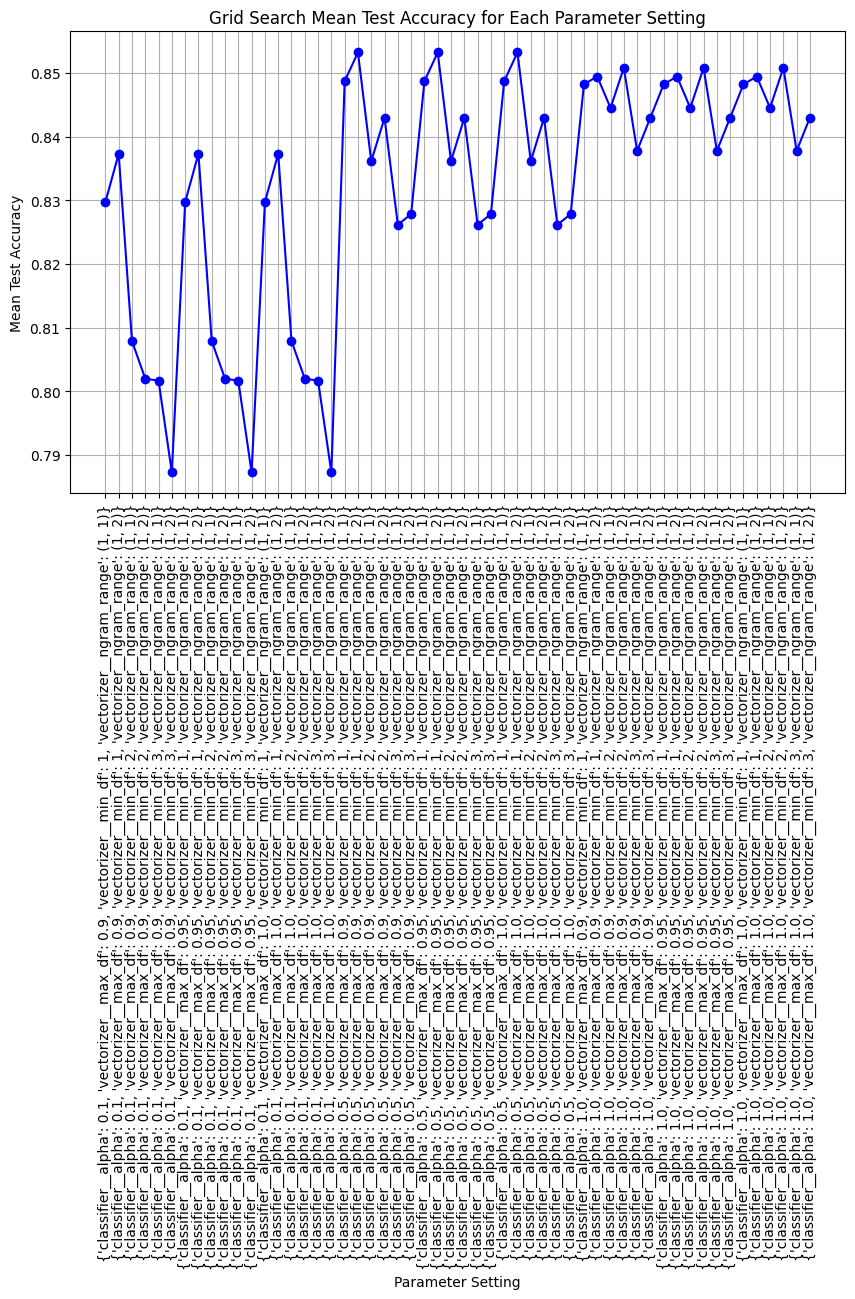

In [ ]:
# Extract the mean test scores for each parameter setting
mean_test_scores = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']

# Plot the mean test scores
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(mean_test_scores)), mean_test_scores, marker='o', linestyle='-', color='b')
plt.xticks(np.arange(len(mean_test_scores)), params, rotation=90)
plt.xlabel('Parameter Setting')
plt.ylabel('Mean Test Accuracy')
plt.title('Grid Search Mean Test Accuracy for Each Parameter Setting')
plt.grid(True)
plt.tight_layout()
plt.show()

Implementation of the model on the real test data with best parameters for naive bayesian.

In [ ]:
# Vectorize the summaries
vectorizer = CountVectorizer(min_df=2, max_df=0.7,ngram_range=(1,2))
X = vectorizer.fit_transform(data['summary'])

nb_classifier = MultinomialNB(alpha=2.0)
nb_classifier.fit(X, y)

# Transform the testing summaries using the fitted vectorizer
testing_v = vectorizer.transform(testing['summary'])

# Predict the severity for the testing data
test_predictions = nb_classifier.predict(testing_v)

testing['severity'] = test_predictions

# Save the results to a CSV file
testing[['bug_id', 'severity']].to_csv('test_predictionsNB.csv', index=False)

**Logistic Regression**

(Restarting step 2 and 3 is required for this part)

In [ ]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(max_iter=5000, solver='liblinear'))  # Specified solver for compatibility
])

# Define the parameter grid to search with fewer parameters
param_grid = {
   'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],  # Uni-gram, bi-gram, and bi-gram only
    'vectorizer__min_df': [1, 2, 3, 5],  # Minimum document frequency
    'vectorizer__max_df': [0.5, 0.7, 0.9],  # Maximum document frequency
    'vectorizer__stop_words': ['english'],  # Including stop words removal
    'vectorizer__max_features': [1000, 5000],  # Maximum number of features
    'classifier__C': [0.1],  # Inverse of regularization strength
    'classifier__penalty': ['l1'],  # Regularization type
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X, y)

# Display the best parameters and corresponding score
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)

# Optionally, you can perform cross-validation with the best parameters
best_pipeline = grid_search.best_estimator_
cv_scores = cross_val_score(best_pipeline, X, y, cv=2)
print("Cross-Validation Scores: ", cv_scores)
print("Mean Cross-Validation Score: ", cv_scores.mean())

Fitting 2 folds for each of 72 candidates, totalling 144 fits
Best Parameters:  {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'vectorizer__max_df': 0.7, 'vectorizer__max_features': 5000, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': 'english'}
Best Accuracy Score:  0.8549731871648396
Cross-Validation Scores:  [0.85453568 0.85538569]
Mean Cross-Validation Score:  0.8549606870085876


Graph for accuracies of the models we tried.

<ipython-input-21-5d2c87f0b6b4>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


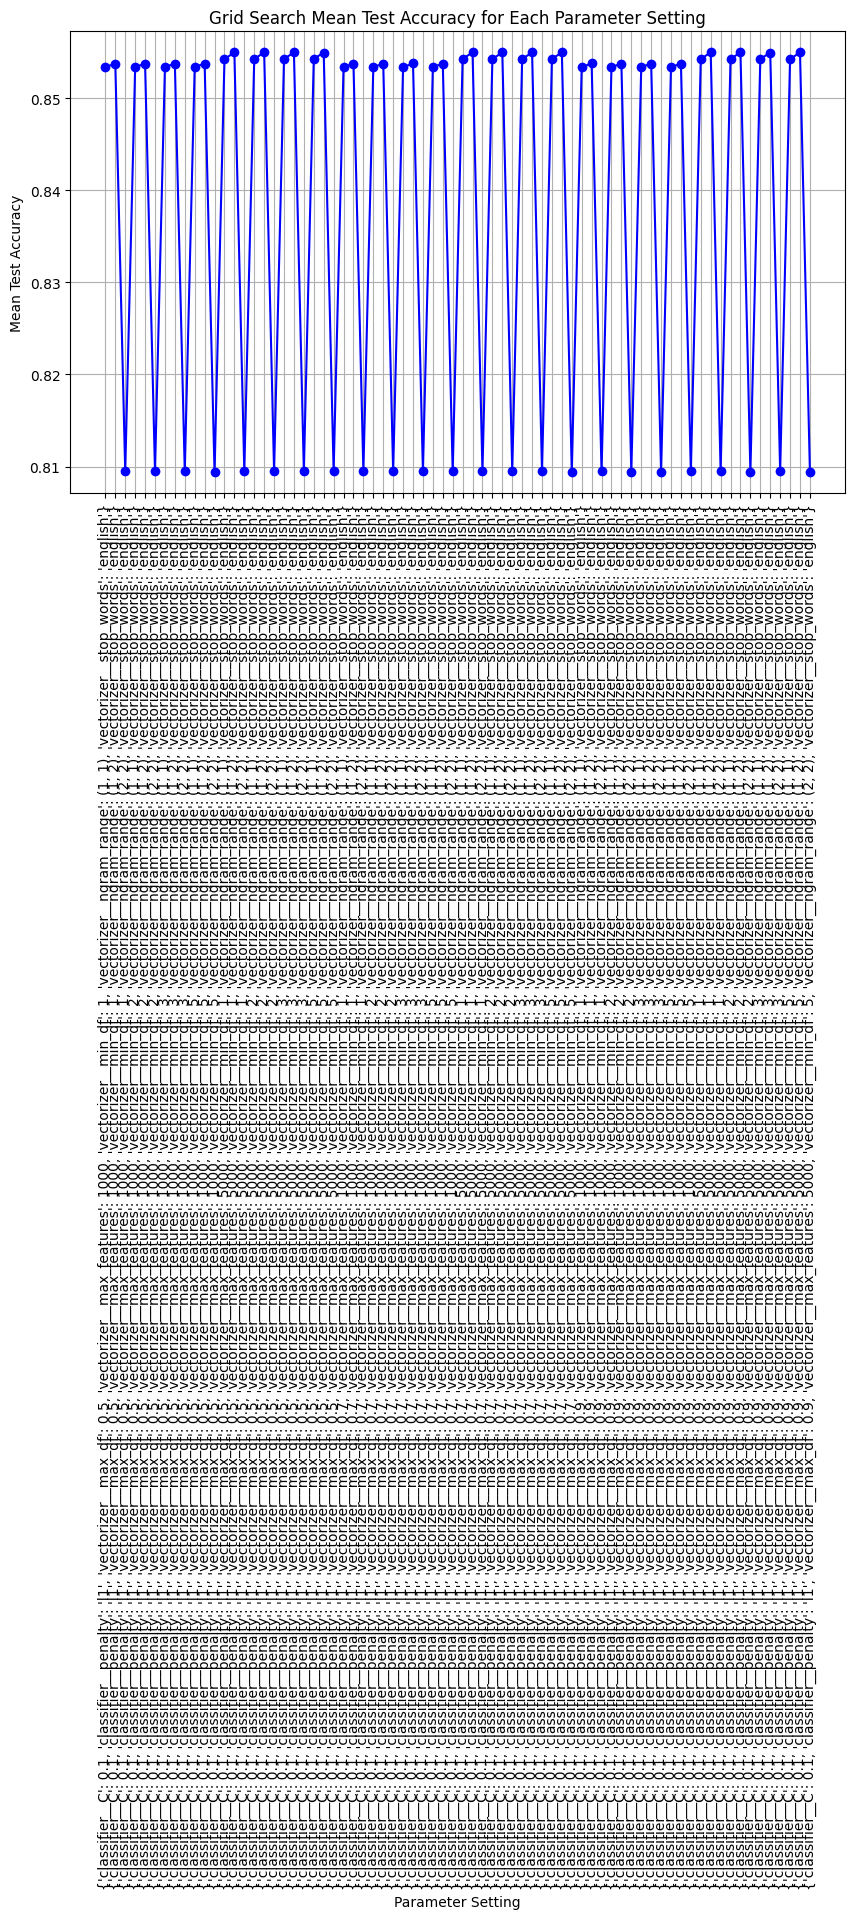

In [ ]:
# Extract the mean test scores for each parameter setting
mean_test_scores = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']

# Plot the mean test scores
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(mean_test_scores)), mean_test_scores, marker='o', linestyle='-', color='b')
plt.xticks(np.arange(len(mean_test_scores)), params, rotation=90)
plt.xlabel('Parameter Setting')
plt.ylabel('Mean Test Accuracy')
plt.title('Grid Search Mean Test Accuracy for Each Parameter Setting')
plt.grid(True)
plt.tight_layout()
plt.show()

Implementation of the model on the real test data with best parameters for logistic regression.


In [ ]:
# Vectorize the summaries
vectorizer = CountVectorizer(min_df=2, max_df=0.7,ngram_range=(1,2))
X = vectorizer.fit_transform(data['summary'])

lr_classifier = LogisticRegression(max_iter=5000, solver='liblinear', C=0.1, penalty = 'l1')
lr_classifier.fit(X, y)

# Transform the testing summaries using the fitted vectorizer
testing_v = vectorizer.transform(testing['summary'])

# Predict the severity for the testing data
test_predictions = lr_classifier.predict(testing_v)

testing['severity'] = test_predictions

# Save the results to a CSV file
testing[['bug_id', 'severity']].to_csv('test_predictionsLR.csv', index=False)

**Random Forest**

Mapping

In [ ]:
# Map severity to numerical labels
severity_mapping = {
    'enhancement': 1,
    'trivial': 2,
    'minor': 3,
    'normal': 4,
    'major': 5,
    'blocker': 6,
    'critical': 7
}

(Restarting step 2 and 3 is required for this part)

In [ ]:
# Vectorize the text
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(X)

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Improved parameter grid
param_grid = {
  'n_estimators': [50, 135],
  'max_features': ['sqrt', 'log2'],
  'max_depth': [20, None],
  'min_samples_split': [2, 10],
  'min_samples_leaf': [1, 4]
}

print("number of models to test = 32")


# Manual grid search
best_score = 0
i = 0
best_params = None
accuracies = []
param_combinations = []

for params in ParameterGrid(param_grid):
    model = RandomForestClassifier(random_state=42, **params)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_val_pred)

    accuracies.append(score)
    param_combinations.append(params)

    if score > best_score:
        best_score = score
        best_params = params

    i += 1

number of models to test = 32


Graph for accuracies of the models we tried.

Best score: 0.85890625
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 135}


<ipython-input-38-6fa62105739d>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to make room for rotated labels


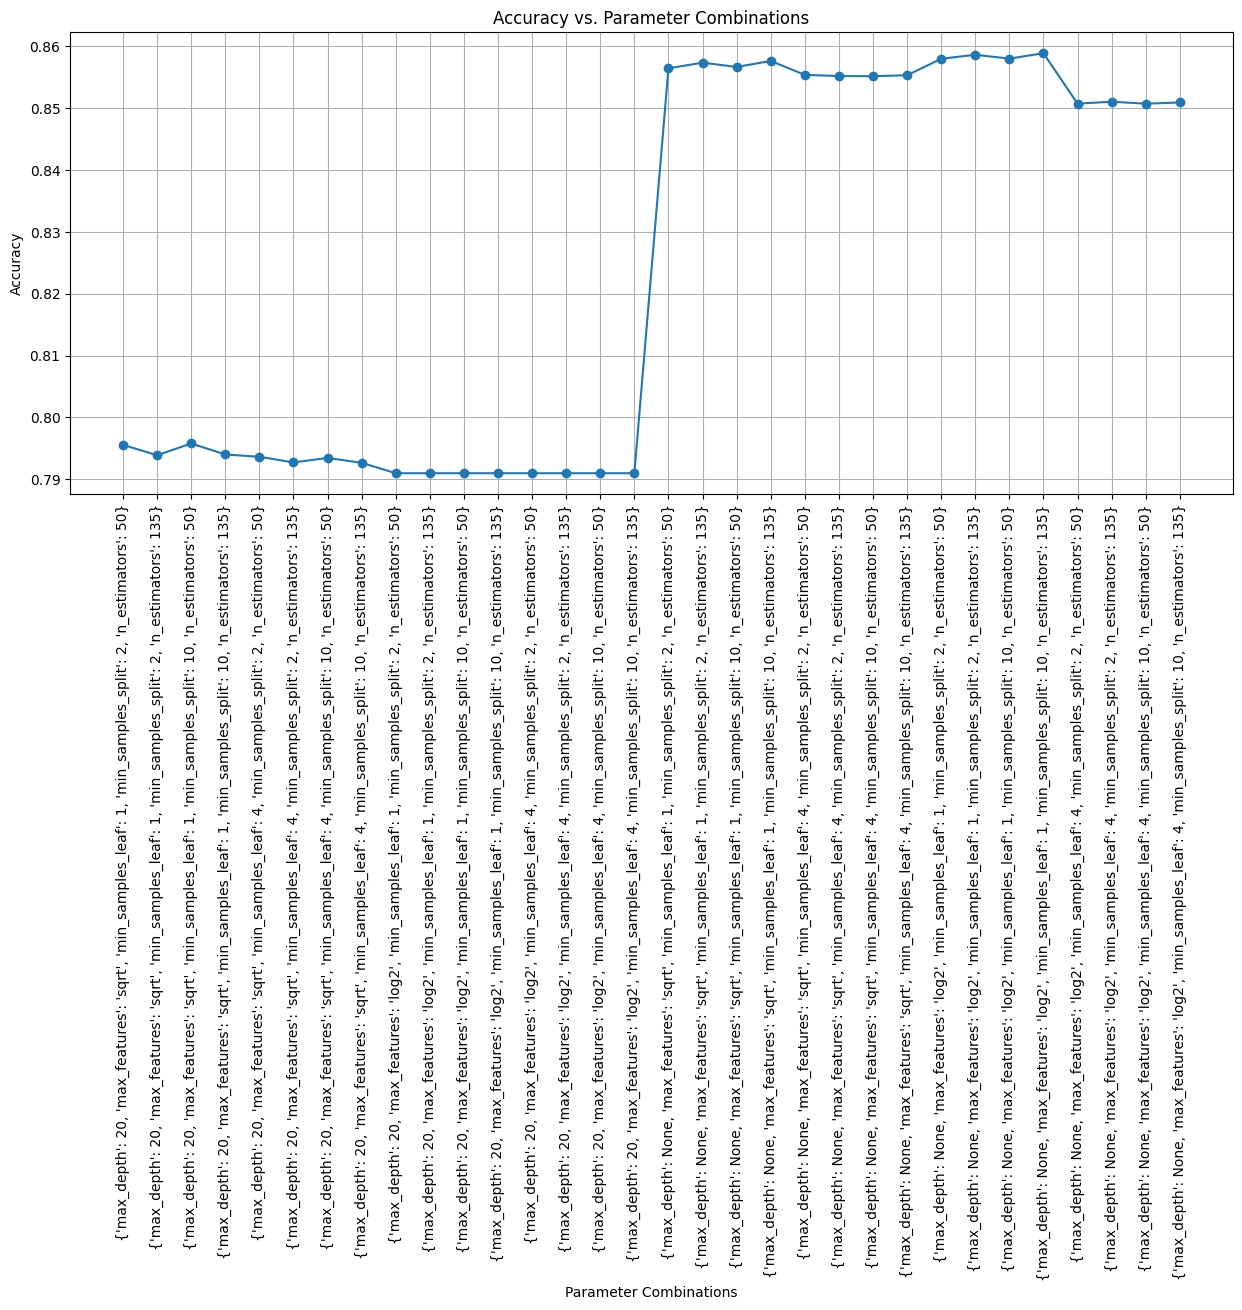

In [ ]:
print("Best score:", best_score)
print("Best parameters:", best_params)

param_labels = [str(params) for params in param_combinations]

plt.figure(figsize=(15, 6))
plt.plot(param_labels, accuracies, marker='o')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Parameter Combinations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Parameter Combinations')
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

Implementation of the model on the real test data with best parameters for random forest.

In [ ]:
# Vectorize the summaries
vectorizer = CountVectorizer(min_df=2, max_df=0.7,ngram_range=(1,2))
X = vectorizer.fit_transform(data['summary'])

rf_classifier = RandomForestClassifier(max_depth = None, max_features = 'log2', min_samples_leaf=1, n_estimators=135 , random_state=42)
rf_classifier.fit(X, y)

# Transform the testing summaries using the fitted vectorizer
testing_v = vectorizer.transform(testing['summary'])

# Predict the severity for the testing data
test_predictions = rf_classifier.predict(testing_v)

testing['severity'] = test_predictions

# Save the results to a CSV file
testing[['bug_id', 'severity']].to_csv('test_predictionsRF.csv', index=False)

Neural Network Implementation w/ optimal parameterization (MLP)


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from google.colab import drive
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# Download necessary NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')

# Mount Google Drive to access datasets
drive.mount('/content/drive')

# Initialize WordNetLemmatizer and stopwords set
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def preprocess(self, text):
        print(f"Original text: {text}")
        text = re.sub(r'\b\d+\b', '', text)  # Remove numbers
        print(f"Text after removing numbers: {text}")
        text = re.sub(r'\W', ' ', text)  # Remove non-alphanumeric characters
        print(f"Text after removing non-alphanumeric characters: {text}")
        words = text.lower().split()  # Convert to lowercase and split into words
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        processed_text = ' '.join(words)
        print(f"Processed text: {processed_text}")
        return processed_text

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.preprocess)

class TextLengthExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lengths = np.array([len(text.split()) for text in X]).reshape(-1, 1)
        print(f"Extracted text lengths: {lengths[:5]}")  # Print first 5 lengths for inspection
        return lengths

# Load the training and test datasets
train_data = pd.read_csv('/content/drive/MyDrive/CS412-Project/Term Project/bugs-train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/CS412-Project/Term Project/bugs-test.csv')

# Check the columns to ensure they match what you expect
print("Training data columns:", train_data.columns)
print("Test data columns:", test_data.columns)

# Inspect the first few rows to verify the data
print("Training data sample:")
print(train_data.head())
print("Test data sample:")
print(test_data.head())

# Extract features and labels from training data
X_train = train_data['summary']
y_train = train_data['severity']

# Extract features from test data
X_test = test_data['summary']

# Convert severity labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
print(f"Encoded severity labels: {y_train_encoded}")

# Create a text preprocessing pipeline
text_preprocessor = TextPreprocessor()
text_length_extractor = TextLengthExtractor()

# Define a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Define models
mlp = MLPClassifier(max_iter=500, random_state=42, verbose=True)

# Create a pipeline with text preprocessing, TF-IDF vectorization, and the classifier
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('preprocess', text_preprocessor),
            ('tfidf', tfidf_vectorizer)
        ])),
        ('length', text_length_extractor)
    ])),
    ('classifier', mlp)  # This will be dynamically set in the param_grid
], verbose=True)

# Define parameter distributions for hyperparameter tuning
param_dist = [
    {
        'features__text__tfidf__max_features': [500, 1000, 5000],
        'classifier': [mlp],
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'classifier__alpha': [0.01, 0.001, 0.0001],
        'classifier__learning_rate_init': [0.01, 0.001, 0.0001]
    },
]

# Define a scoring function for macro precision
scorer = make_scorer(precision_score, average='macro')

# Perform randomized search cross-validation to find the best hyperparameters
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=2, scoring=scorer, n_jobs=-1, random_state=42, verbose=10)

# Fit the randomized search to the training data
print("Starting RandomizedSearchCV fitting...")
random_search.fit(X_train, y_train_encoded)
print("RandomizedSearchCV fitting complete.")

# Display the best parameters and best cross-validated macro precision
print("Best parameters found:", random_search.best_params_)
print("Best cross-validated macro precision:", random_search.best_score_)

# Fit the best model on the entire training data
best_model = random_search.best_estimator_
print("Fitting the best model to the entire training data...")
best_model.fit(X_train, y_train_encoded)
print("Best model fitting complete.")

# Predict on the test set
print("Predicting on the test set...")
y_pred = best_model.predict(X_test)
print("Prediction complete.")

# Map the predicted labels back to original severity labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
print("Predicted severity labels:", y_pred_labels)

# Output predictions
test_data['predicted_severity'] = y_pred_labels
print("Test data with predictions:")
print(test_data.head())

# Save the predictions to a CSV file
output_path = '/content/drive/MyDrive/CS412-Project/Term Project/mlp_preds.csv'
test_data.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")


Neural Network Implementation w/o optimal parameterization (MLP)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
from google.colab import drive
from sklearn.ensemble import GradientBoostingClassifier

nltk.download('stopwords')
nltk.download('wordnet')
drive.mount('/content/drive')

# Initialize WordNetLemmatizer and stopwords set outside of the class
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def preprocess(self, text):
        text = re.sub(r'\b\d+\b', '', text)  # Remove numbers
        text = re.sub(r'\W', ' ', text)  # Remove non-alphanumeric characters
        words = text.lower().split()
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        return ' '.join(words)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.preprocess)

class TextLengthExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([len(text.split()) for text in X]).reshape(-1, 1)

# Load the training and test datasets
train_data = pd.read_csv('/content/drive/MyDrive/CS412-Project/Term Project/bugs-train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/CS412-Project/Term Project/bugs-test.csv')

# Check the columns to ensure they match what you expect
print("Training data columns:", train_data.columns)
print("Test data columns:", test_data.columns)

# Inspect the first few rows to verify the data
print("Training data sample:")
print(train_data.head())
print("Test data sample:")
print(test_data.head())

# Extract features and labels from training data
X_train = train_data['summary']
y_train = train_data['severity']

# Extract features from test data
X_test = test_data['summary']

# Convert severity labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Create a text preprocessing pipeline
text_preprocessor = TextPreprocessor()
text_length_extractor = TextLengthExtractor()

# Define a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Define the classifier (choose one: MLPClassifier or GradientBoostingClassifier)
classifier = MLPClassifier(max_iter=20, hidden_layer_sizes=(100,), alpha=0.001, learning_rate_init=0.001, random_state=42, verbose=True)
# Uncomment the following line and comment the MLPClassifier line above to use GradientBoostingClassifier instead
# classifier = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200, max_depth=5, random_state=42)

# Create a pipeline with text preprocessing, TF-IDF vectorization, and the classifier
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('preprocess', text_preprocessor),
            ('tfidf', tfidf_vectorizer)
        ])),
        ('length', text_length_extractor)
    ])),
    ('classifier', classifier)
])

# Define a scoring function for macro precision with zero_division set to handle undefined precision
scorer = make_scorer(precision_score, average='macro', zero_division=0)

# Split the training data for cross-validation (if needed)
X_train_cv, X_val_cv, y_train_cv, y_val_cv = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train_encoded)

# Predict on the validation set (if cross-validation is needed)
y_val_pred = pipeline.predict(X_val_cv)
val_precision = precision_score(y_val_cv, y_val_pred, average='macro', zero_division=0)
print("Validation macro precision:", val_precision)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Map the predicted labels back to original severity labels
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Output predictions
test_data['predicted_severity'] = y_pred_labels
print("Test data with predictions:")
print(test_data)

# If you want to save the predictions to a CSV file
test_data.to_csv('/content/drive/MyDrive/CS412-Project/Term Project/test_data_with_predictions.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive
Training data columns: Index(['bug_id', 'summary', 'severity'], dtype='object')
Test data columns: Index(['bug_id', 'summary'], dtype='object')
Training data sample:
   bug_id                                            summary  severity
0  365569                  Remove workaround from bug 297227    normal
1  365578    Print Preview crashes on any URL in gtk2 builds  critical
2  365582                     Lines are not showing in table     major
3  365584  Firefox render ÛÏsimplified ArabicÛ font fa...    normal
4  365597             Crash [@ nsINodeInfo::NodeInfoManager]  critical
Test data sample:
    bug_id                                            summary
0  1143402  Firefox claims to be not the default browser w...
1  1143405  Background of html and body element are not ap...
2  1143409  Mouse input breaks after using window.showModa...
3  1143411  Build failure with next freetype version/curre...
4  1143417  HTML element is not treated as root inside

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation macro precision: 0.8585665496016753
Test data with predictions:
        bug_id                                            summary  \
0      1143402  Firefox claims to be not the default browser w...   
1      1143405  Background of html and body element are not ap...   
2      1143409  Mouse input breaks after using window.showModa...   
3      1143411  Build failure with next freetype version/curre...   
4      1143417  HTML element is not treated as root inside for...   
...        ...                                                ...   
86089  1426166      Crash in bool IsAboutToBeFinalizedInternal<T>   
86090  1426171  Potential crash if GraphRate is greater than 4...   
86091  1426173  Crash in <name omitted> | decltype JS::Dispatc...   
86092  1426174  Crash in xul.dll@0x28145fa | xul.dll@0x3c748ff...   
86093  1426176  No symbols for clang_rt.asan_dynamic-x86_64.dl...   

      predicted_severity  
0                 normal  
1                 normal  
2              